# Note : IN PROGRESS

In [1]:
import re
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from nltk.corpus import stopwords

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1. 캡션 데이터 분석

In [2]:
#trainCaps = pd.read_csv('COCO/annotations/captions_train2017.csv', index_col=0)
#valCaps = pd.read_csv('COCO/annotations/captions_val2017.csv', index_col=0)
#captions = pd.DataFrame.append(trainCaps, valCaps, ignore_index=True)
captions = pd.read_csv('COCO/annotations/captions_train2017.csv', index_col=0)

In [3]:
print('전체 훈련 캡션 개수 : ', len(captions))

전체 훈련 캡션 개수 :  591753


In [4]:
captionLen = captions['caption'].astype(str).apply(len)
captionLen.head(20)

0      57
1      58
2      41
3     150
4      69
5      50
6      41
7      54
8      45
9      56
10     54
11     57
12     67
13     63
14     59
15     53
16     65
17     51
18     46
19     49
Name: caption, dtype: int64

Text(0, 0.5, 'Number of train captions')

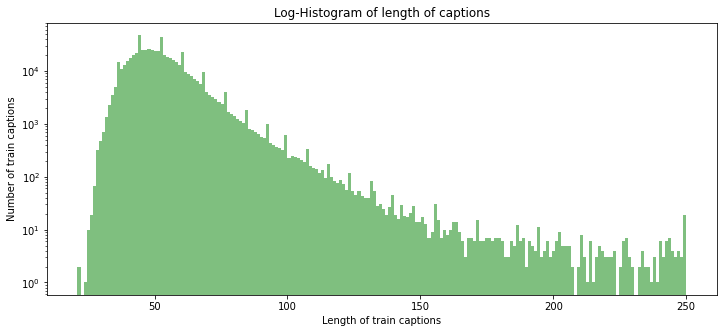

In [5]:
# 그래프
plt.figure(figsize=(12,5))
plt.hist(captionLen, bins=200, alpha=0.5, color='g', label='word')
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of length of captions')
plt.xlabel('Length of train captions')
plt.ylabel('Number of train captions')

In [6]:
print('캡션 길이 최댓값 ', np.max(captionLen))
print('캡션 길이 최솟값 ', np.min(captionLen))
print('캡션 길이 평균값 ', np.mean(captionLen))
print('캡션 길이 표준편차 ', np.std(captionLen))
print('캡션 길이 중간값 ', np.median(captionLen))
print('캡션 길이 제1사분위 ', np.percentile(captionLen, 25))
print('캡션 길이 제3사분위 ', np.percentile(captionLen, 75))

캡션 길이 최댓값  250
캡션 길이 최솟값  21
캡션 길이 평균값  52.4888678215404
캡션 길이 표준편차  12.699521867138166
캡션 길이 중간값  50.0
캡션 길이 제1사분위  44.0
캡션 길이 제3사분위  58.0


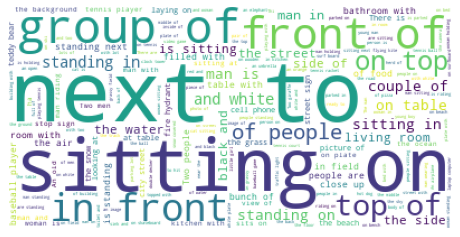

In [7]:
# 워드 클라우드
words = [caps for caps in captions['caption'] if type(caps) is str]
wordcloud = WordCloud(relative_scaling=0.5,
                      background_color = 'white').generate(' '.join(words))
plt.figure(figsize=(8,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 2. 데이터 전처리

In [8]:
captions['caption'][0]

'A man with a red helmet on a small moped on a dirt road. '

In [9]:
def preprocessing(data, remove_stopwords=False):
    # 특수문자 공백으로 치환
    text = re.sub("[^a-zA-Z]", " ", data)
    # 대문자를 소문자로 치환, 공백단위로 나눠서 리스트로 만든다
    words = text.lower().split()
    
    if remove_stopwords:
        # 불용어 제거
        stops = set(stopwords.words("english"))
        # 불용어가 아닌 단어로 이루어진 새로운 리스트 생성
        words = [w for w in words if not w in stops]
        # 단어 리스트를 공백을 넣어서 하나의 글로 합침
        clean_caption = ' '.join(words)
    else :
        # 불용어 제거 안할때
        clean_caption = ' '.join(words)

    return clean_caption

In [10]:
clean_cap = []

In [11]:
for data in tqdm_notebook(captions['caption']):
    clean_cap.append(preprocessing(data, remove_stopwords=True))

In [12]:
clean_cap[0]

'man red helmet small moped dirt road'

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_cap)
text_sequences = tokenizer.texts_to_sequences(clean_cap)

In [14]:
print(text_sequences[0])

[1, 27, 468, 17, 1603, 184, 58]


In [15]:
word_vocab = tokenizer.word_index
print(word_vocab)

{'man': 1, 'sitting': 2, 'two': 3, 'standing': 4, 'people': 5, 'next': 6, 'white': 7, 'woman': 8, 'street': 9, 'table': 10, 'holding': 11, 'person': 12, 'large': 13, 'top': 14, 'group': 15, 'field': 16, 'small': 17, 'tennis': 18, 'near': 19, 'front': 20, 'black': 21, 'train': 22, 'plate': 23, 'room': 24, 'dog': 25, 'riding': 26, 'red': 27, 'cat': 28, 'young': 29, 'water': 30, 'baseball': 31, 'playing': 32, 'walking': 33, 'bathroom': 34, 'sign': 35, 'blue': 36, 'kitchen': 37, 'food': 38, 'grass': 39, 'bus': 40, 'green': 41, 'pizza': 42, 'parked': 43, 'side': 44, 'building': 45, 'bed': 46, 'looking': 47, 'snow': 48, 'beach': 49, 'ball': 50, 'couple': 51, 'three': 52, 'boy': 53, 'men': 54, 'toilet': 55, 'clock': 56, 'city': 57, 'road': 58, 'flying': 59, 'wearing': 60, 'skateboard': 61, 'player': 62, 'game': 63, 'several': 64, 'girl': 65, 'laying': 66, 'sits': 67, 'wooden': 68, 'bench': 69, 'picture': 70, 'area': 71, 'bear': 72, 'one': 73, 'laptop': 74, 'around': 75, 'horse': 76, 'eating':

In [16]:
print("total vocab size : ", len(word_vocab))

total vocab size :  26323


In [17]:
# 데이터 사전을 json 형태로 저장
data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)+1
json.dump(data_configs, open('COCO/annotations/word_dict.json', 'w'), ensure_ascii=False)